Taken from chapter7 of deep learning with pytorch.

We will approach a simple image recognition problem step by step, building from
a simple neural network like the one we defined in the last chapter. This time, instead
of a tiny dataset of numbers, we’ll use a more extensive dataset of tiny images. Let’s
download the dataset first and get to work preparing it for use.

### A dataset of tiny images

There is nothing like an intuitive understanding of a subject, and there is nothing to
achieve that like working on simple data. One of the most basic datasets for image
recognition is the handwritten digit-recognition dataset known as MNIST. Here
we will use another dataset that is similarly simple and a bit more fun. It’s called
CIFAR-10, and, like its sibling CIFAR-100, it has been a computer vision classic for
a decade.

CIFAR-10 consists of 60,000 tiny 32 × 32 color (RGB) images, labeled with an integer corresponding to 1 of 10 classes: airplane (0), automobile (1), bird (2), cat (3),
deer (4), dog (5), frog (6), horse (7), ship (8), and truck (9).1
 Nowadays, CIFAR-10 is
considered too simple for developing or validating new research, but it serves our
learning purposes just fine. We will use the torchvision module to automatically
download the dataset and load it as a collection of PyTorch tensors

### Downloading CIFAR-10

As we anticipated, let’s import torchvision and use the datasets module to download the CIFAR-10 data:

In [25]:
from torchvision import datasets

In [26]:
data_path = './'

cifar10 =  datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


Just like CIFAR10, the datasets submodule gives us precanned access to the most
popular computer vision datasets, such as MNIST, Fashion-MNIST, CIFAR-100,
SVHN, Coco, and Omniglot. In each case, the dataset is returned as a subclass of
torch.utils.data.Dataset. We can see that the method-resolution order of our
cifar10 instance includes it as a base class:

In [27]:
type(cifar10).__mro__ # method resolution order

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

### The dataset class

It’s a good time to discover what being a subclass of torch.utils.data.Dataset
means in practice.It
is an object that isrequired to implement twomethods: `__len__` and `__getitem__`

In [28]:
len(cifar10)

50000

Similarly, since the dataset is equipped with the __getitem__ method, we can use the
standard subscript for indexing tuples and lists to access individual items. Here, we get
a PIL (Python Imaging Library, the PIL package) image with our desired output—an
integer with the value 1, corresponding to “automobile

In [29]:
img, label = cifar10[99]
img, label

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F201A24CA90>, 1)

In [30]:
import matplotlib.pyplot as plt

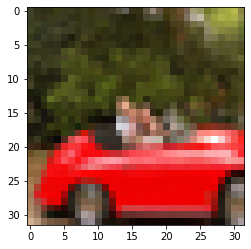

In [31]:
plt.imshow(img)
plt.show()

### Data transforms

That’s all very nice, but we’ll likely need a way to convert the PIL image to a PyTorch
tensor before we can do anything with it. That’s where torchvision.transforms
comes in. This module defines a set of composable, function-like objects that can be
passed as an argument to a torchvision dataset such as datasets.CIFAR10(…), and
that perform transformations on the data after it is loaded but before it is returned by
__getitem__. We can see the list of available objects as follows:

In [32]:
from torchvision import transforms

dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

Among those transforms, we can spot ToTensor, which turns NumPy arrays and PIL
images to tensors. It also takes care to lay out the dimensions of the output tensor as
C × H × W (channel, height, width;).
 Let’s try out the ToTensor transform. Once instantiated, it can be called like a
function with the PIL image as the argument, returning a tensor as output:

In [33]:
from torchvision import transforms

In [34]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

The image has been turned into a 3 × 32 × 32 tensor and therefore a 3-channel (RGB)
32 × 32 image. Note that nothing has happened to label; it is still an integer.
 As we anticipated, we can pass the transform directly as an argument to dataset
.CIFAR10:

In [35]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

At this point, accessing an element of the dataset will return a tensor, rather than a
PIL image:

In [36]:
img_t,_ = tensor_cifar10[99]

type(img_t)

torch.Tensor

As expected, the shape has the channel as the first dimension, while the scalar type is
float32:


In [37]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

Whereas the values in the original PIL image ranged from 0 to 255 (8 bits per channel), the ToTensor transform turns the data into a 32-bit floating-point per channel,
scaling the values down from 0.0 to 1.0. Let’s verify that:

In [38]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))


and lets verify if we have the same image out

Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


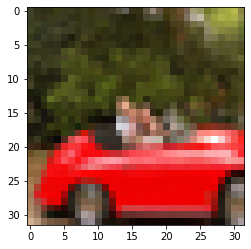

In [39]:
try:
    plt.imshow(img_t)
except Exception as e:
    print(e)
print(img_t.shape, img_t.permute(1,2,0).shape)
plt.imshow(img_t.permute(1,2,0))
plt.show()

It checks. Note how we have to use permute to change the order of the axes from
C × H × W to H × W × C to match what Matplotlib expects. 

### Normalizing data

Transforms are really handy because we can chain them using transforms.Compose,
and they can handle normalization and data augmentation transparently, directly in
the data loader. For instance, it’s good practice to normalize the dataset so that each
channel has zero mean and unitary standard deviation.

we also have an intuition for why: by choosing
activation functions that are linear around 0 plus or minus 1 (or 2), keeping the data
in the same range means it’s more likely that neurons have nonzero gradients and hence, will learn sooner. Also, normalizing each channel so that it has the same
distribution will ensure that channel information can be mixed and updated through
gradient descent using the same learning rate.

In order to make it so that each channel has zero mean and unitary standard deviation, we can compute the mean value and the standard deviation of each channel
across the dataset and apply the following transform: v_n[c] = (v[c] - mean[c]) /
stdev[c]. This is what transforms.Normalize does. The values of mean and stdev
must be computed offline (they are not computed by the transform). Let’s compute
them for the CIFAR-10 training set.

In [40]:
import torch

In [41]:
imgs = torch.stack([img_t for img_t ,_ in tensor_cifar10],dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

lets compute mean per channel

In [42]:
imgs.view(3,-1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

Recall that view(3, -1) keeps the three channels and
merges all the remaining dimensions into one, figuring
out the appropriate size. Here our 3 × 32 × 32 image is
transformed into a 3 × 1,024 vector, and then the mean
is taken over the 1,024 elements of each channel.

In [43]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

With these numbers in our hands, we can initialize the Normalize transform


In [44]:
transforms.Normalize((0.4915, 0.4823, .4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

and concatenate it after the ToTensor transform:

In [45]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
]))

In [46]:
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
]))

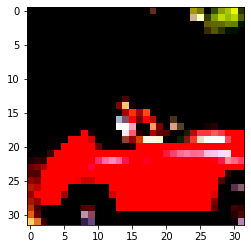

In [47]:
img_t , _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1,2,0))

plt.show()

This is because normalization
has shifted the RGB levels outside the 0.0 to 1.0 range and changed the overall magnitudes of the channels. All of the data is still there; it’s just that Matplotlib renders it as
black. We’ll keep this in mind for the future.

### Distinguishing birds from aeroplanes

Lets try making a very simple non superman detector.

### Building the dataset

The first step is to get the data in the right shape. We could create a Dataset subclass
that only includes birds and airplanes. However, the dataset is small, and we only need
indexing and len to work on our dataset. It doesn’t actually have to be a subclass of
torch.utils.data.dataset.Dataset! Well, why not take a shortcut and just filter the
data in cifar10 and remap the labels so they are contiguous? Here’s how:

In [48]:
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']

In [49]:
cifar2 = [(img, label_map[label])
for img, label in transformed_cifar10
if label in [0, 2]]

In [50]:
cifar2_val = [(img, label_map[label])
for img, label in transformed_cifar10_val
if label in [0, 2]]

The cifar2 object satisfies the basic requirements for a Dataset—that is, __len__ and
__getitem__ are defined—so we’re going to use that. We should be aware, however,
that this is a clever shortcut and we might wish to implement a proper Dataset if we
hit limitations with it.4
 We have a dataset! Next, we need a model to feed our data to. 

### A fully connected model

We learned how to build a neural network in chapter 5. We know that it’s a tensor of
features in, a tensor of features out. After all, an image is just a set of numbers laid out
in a spatial configuration. OK, we don’t know how to handle the spatial configuration
part just yet, but in theory if we just take the image pixels and straighten them into a
long 1D vector, we could consider those numbers as input features, right?

In [51]:
import torch.nn as nn

In [52]:
n_out = 2
model = nn.Sequential(
    nn.Linear(
        3072, 512
    ),
    nn.Tanh(),
    nn.Linear(512, n_out)
)

We somewhat arbitrarily pick 512 hidden features. A neural network needs at least
one hidden layer (of activations, so two modules) with a nonlinearity in between in
order to be able to learn arbitrary functions in the way we discussed in section 6.3—
otherwise, it would just be a linear model. The hidden features represent (learned)
relations between the inputs encoded through the weight matrix. As such, the model
might learn to “compare” vector elements 176 and 208, but it does not a priori focus
on them because it is structurally unaware that these are, indeed (row 5, pixel 16) and
(row 6, pixel 16), and thus adjacent.

### Output of a classifier

Casting the problem in terms of probabilities imposes a few extra constraints on
the outputs of our network:

Each element of the output must be in the [0.0, 1.0] range (a probability of
an outcome cannot be less than 0 or greater than 1).

The elements of the output must add up to 1.0 (we’re certain that one of the
two outcomes will occur).

It sounds like a tough constraint to enforce in a differentiable way on a vector of numbers. Yet there’s a very smart trick that does exactly that, and it’s differentiable: it’s
called softmax. 

### Representing the output as probabilities

Softmax is a function that takes a vector of values and produces another vector of the
same dimension, where the values satisfy the constraints we just listed to represent
probabilities.

That is, we take the elements of the vector, compute the elementwise exponential,
and divide each element by the sum of exponentials. In code, it’s something like this:

In [53]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [54]:
x = torch.tensor([1.0,2.0, 3.0])

In [55]:
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [56]:
softmax(x).sum()

tensor(1.)

Softmax is a monotone function, in that lower values in the input will correspond to
lower values in the output. However, it’s not scale invariant, in that the ratio between
values is not preserved. In fact, the ratio between the first and second elements of the
input is 0.5, while the ratio between the same elements in the output is 0.3678. This is
not a real issue, since the learning process will drive the parameters of the model in a
way that values have appropriate ratios.
 The nn module makes softmax available as a module. Since, as usual, input tensors
may have an additional batch 0th dimension, or have dimensions along which they
encode probabilities and others in which they don’t, nn.Softmax requires us to specify
the dimension along which the softmax function is applied:

In [57]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0,2.0,3.0],
                  [1.0,2.0,3.0]])

In [58]:
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In this case, we have two input vectors in two rows (just like when we work with
batches), so we initialize nn.Softmax to operate along dimension 1.
 Excellent! We can now add a softmax at the end of our model, and our network
will be equipped to produce probabilities:

In [59]:
model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.Softmax(dim=1)
    )

We can actually try running the model before even training it. Let’s do it, just to see
what comes out. We first build a batch of one image, our bird

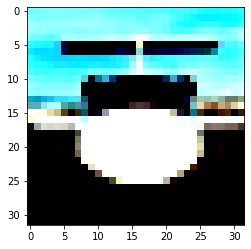

In [60]:
img, _ = cifar2[99]

plt.imshow(img.permute(1,2,0))

Oh, hello there. In order to call the model, we need to make the input have the right
dimensions. We recall that our model expects 3,072 features in the input, and that nn
works with data organized into batches along the zeroth dimension. So we need to
turn our 3 × 32 × 32 image into a 1D tensor and then add an extra dimension in the
zeroth position

In [61]:
img.shape

torch.Size([3, 32, 32])

In [62]:
img.view(-1).shape

torch.Size([3072])

In [63]:
try:
    img_batch = img.view(-1).unsqueeze(0)
except Exception as e:
    print(e)

In [64]:
out = model(img_batch)
out

tensor([[0.6301, 0.3699]], grad_fn=<SoftmaxBackward>)

So, we got probabilities! Well, we know we shouldn’t get too excited: the weights and
biases of our linear layers have not been trained at all. Their elements are initialized
randomly by PyTorch between –1.0 and 1.0. Interestingly, we also see grad_fn for the
output, which is the tip of the backward computation graph (it will be used as soon as
we need to backpropagate).

The network can’t even tell
that at this point. It’s the loss function that associates a meaning with these two numbers, after backpropagation. If the labels are provided as index 0 for “airplane” and
index 1 for “bird,” then that’s the order the outputs will be induced to take. Thus,
after training, we will be able to get the label as an index by computing the argmax of
the output probabilities: that is, the index at which we get the maximum probability.
Conveniently, when supplied with a dimension, torch.max returns the maximum element along that dimension as well as the index at which that value occurs. In our case,
we need to take the max along the probability vector (not across batches), therefore,
dimension 1:

In [65]:
_, index = torch.max(out, dim=1)

index

tensor([0])

It says the image is a bird. Pure luck. But we have adapted our model output to the
classification task at hand by getting it to output probabilities. We also have now run
our model against an input image and verified that our plumbing works. Time to get
training. As in the previous two chapters, we need a loss to minimize during training. 

### A loss for classfiying

Looking back at the
argmax operation we used to extract the index of the predicted class, what we’re really
interested in is that the first probability is higher than the second for airplanes and vice
versa for birds. In other words, we want to penalize misclassifications rather than painstakingly penalize everything that doesn’t look exactly like a 0.0 or 1.0.

What we need to maximize in this case is the probability associated with the correct
class, out[class_index], where out is the output of softmax and class_index is a vector containing 0 for “airplane” and 1 for “bird” for each sample. This quantity—that
is, the probability associated with the correct class—is referred to as the likelihood (of
our model’s parameters, given the data).8
 In other words, we want a loss function that
is very high when the likelihood is low: so low that the alternatives have a higher probability. 

 There’s a loss function that behaves that way, and it’s called negative log likelihood
(NLL). It has the expression NLL = - sum(log(out_i[c_i])), where the sum is taken
over N samples and c_i is the correct class for sample i. Let’s take a look at figure 7.10,
which shows the NLL as a function of predicted probability

Summing up, our loss for classification can be computed as follows. For each sample in the batch:

1 Run the forward pass, and obtain the output values from the last (linear) layer.

2 Compute their softmax, and obtain probabilities.

3 Take the predicted probability corresponding to the correct class (the likelihood of the parameters). Note that we know what the correct class is because
it’s a supervised problem—it’s our ground truth.

4 Compute its logarithm, slap a minus sign in front of it, and add it to the loss.

In [66]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9,0.1],
    [0.3, 0.7],
    [0.2, 0.8]
])

class_index = torch.tensor([0,0,1,1]).unsqueeze(1)

truth = torch.zeros((4,2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

### Training the classfier

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(),lr=learning_rate)

In [ ]:
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: %d, Loss %f" % (epoch, float(loss)))

Epoch: 0, Loss 7.222799
Epoch: 1, Loss 1.883938
Epoch: 2, Loss 10.100144
Epoch: 3, Loss 4.955270
Epoch: 4, Loss 3.700928
Epoch: 5, Loss 7.842928
Epoch: 6, Loss 10.949423
Epoch: 7, Loss 2.339513
Epoch: 8, Loss 6.712431
Epoch: 9, Loss 13.361099
Epoch: 10, Loss 4.209538
Epoch: 11, Loss 4.661271
Epoch: 12, Loss 9.625241
Epoch: 13, Loss 6.211294
Epoch: 14, Loss 8.326766
Epoch: 15, Loss 5.311778
Epoch: 16, Loss 0.598872
Epoch: 17, Loss 0.007767
Epoch: 18, Loss 1.933518
Epoch: 19, Loss 2.297608
Epoch: 20, Loss 3.862087
Epoch: 21, Loss 3.553736
Epoch: 22, Loss 0.240335
Epoch: 23, Loss 5.221899
Epoch: 24, Loss 6.085196
Epoch: 25, Loss 14.825875
Epoch: 26, Loss 6.812384
Epoch: 27, Loss 10.024420
Epoch: 28, Loss 11.113656
Epoch: 29, Loss 0.188393
Epoch: 30, Loss 7.740237
Epoch: 31, Loss 7.331666
Epoch: 32, Loss 12.096233
Epoch: 33, Loss 1.837277
Epoch: 34, Loss 2.919860
Epoch: 35, Loss 5.839210
Epoch: 36, Loss 1.502855
Epoch: 37, Loss 7.376925
Epoch: 38, Loss 8.335595
Epoch: 39, Loss 6.007591


This time we have incorporated thta in training loop each image may be independently catered to. By shuffling samples at each eppoch we are essentially introducing randomness in our gradient

Remember SGD? It stands for stochastic gradient descent, and this is what the S is about:
working on small batches (aka minibatches) of shuffled data. It turns out that following
gradients estimated over minibatches, which are poorer approximations of gradients
estimated across the whole dataset, helps convergence and prevents the optimization
process from getting stuck in local minima it encounters along the way

In our training code, we chose minibatches of size 1 by picking one item at a time from
the dataset. The torch.utils.data module has a class that helps with shuffling and
organizing the data in minibatches: DataLoader. The job of a data loader is to sample
minibatches from a dataset, giving us the flexibility to choose from different sampling
strategies. A very common strategy is uniform sampling after shuffling the data at each
epoch. Figure 7.14 shows the data loader shuffling the indices it gets from the Dataset.

Let’s see how this is done. At a minimum, the DataLoader constructor takes a Dataset
object as input, along with batch_size and a shuffle Boolean that indicates whether
the data needs to be shuffled at the beginning of each epoch:


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

A DataLoader can be iterated over, so we can use it directly in the inner loop of our
new training code:

In [ ]:
import torch
import torch.nn as nn

train_loader = torch.utils.data.Dataloader(cifar2, batch_size=64, shuffle=True)

In [ ]:
model = nn.sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

In [ ]:
learning_rate = 1e-2


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_Size = imgs.shape[0]
        outputs = model(imgs.view(batch_size,-1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch: ", epoch, " loss: ", float(loss))

We see that the loss decreases somehow, but we have no idea whether it’s low enough.
Since our goal here is to correctly assign classes to images, and preferably do that on
an independent dataset, we can compute the accuracy of our model on the validation
set in terms of the number of correct classifications over the total

In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: " correct/total)

Not a great performance, but quite a lot better than random. In our defense, our
model was quite a shallow classifier; it’s a miracle that it worked at all. It did because
our dataset is really simple—a lot of the samples in the two classes likely have systematic differences (such as the color of the background) that help the model tell birds
from airplanes, based on a few pixels.


In [ ]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1)
)

Here we are trying to taper the number of features more gently toward the output, in
the hope that intermediate layers will do a better job of squeezing information in
increasingly shorter intermediate outputs.
 

The combination of nn.LogSoftmax and nn.NLLLoss is equivalent to using
nn.CrossEntropyLoss. This terminology is a particularity of PyTorch, as the
nn.NLLoss computes, in fact, the cross entropy but with log probability predictions as
inputs where nn.CrossEntropyLoss takes scores (sometimes called logits). Technically, nn.NLLLoss is the cross entropy between the Dirac distribution, putting all mass
on the target, and the predicted distribution given by the log probability inputs.

 To add to the confusion, in information theory, up to normalization by sample size,
this cross entropy can be interpreted as a negative log likelihood of the predicted distribution under the target distribution as an outcome. So both losses are the negative
log likelihood of the model parameters given the data when our model predicts the
(softmax-applied) probabilities. In this book, we won’t rely on these details, but don’t
let the PyTorch naming confuse you when you see the terms used in the literature.

lets drop the softmax

In [ ]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.tanh(),
    nn.linear(128, 2)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

Note that the numbers will be exactly the same as with nn.LogSoftmax and nn.NLLLoss.
It’s just more convenient to do it all in one pass, with the only gotcha being that the output of our model will not be interpretable as probabilities (or log probabilities). We’ll
need to explicitly pass the output through a softmax to obtain those

Lets look at the parameters

In [ ]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

. In our full network,
we had 1,024 output features, which led the first linear module to have 3 million
parameters. This shouldn’t be unexpected: we know that a linear layer computes y =
weight * x + bias, and if x has length 3,072 (disregarding the batch dimension for
simplicity) and y must have length 1,024, then the weight tensor needs to be of size
1,024 × 3,072 and the bias size must be 1,024. And 1,024 * 3,072 + 1,024 = 3,146,752,
as we found earlier. We can verify these quantities directly:

In [ ]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

What is this telling us? That our neural network won’t scale very well with the number
of pixels. What if we had a 1,024 × 1,024 RGB image? That’s 3.1 million input values.
Even abruptly going to 1,024 hidden features (which is not going to work for our classifier), we would have over 3 billion parameters. Using 32-bit floats, we’re already at 12
GB of RAM, and we haven’t even hit the second layer, much less computed

### limits of going fully connected

1. a fully connected network is not translation invariant
2. we need to use data augmentation techniques